In [17]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import urllib.parse
import pandas as pd
import urllib.robotparser
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/linuxperso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
client=MongoClient('localhost', port=27017)

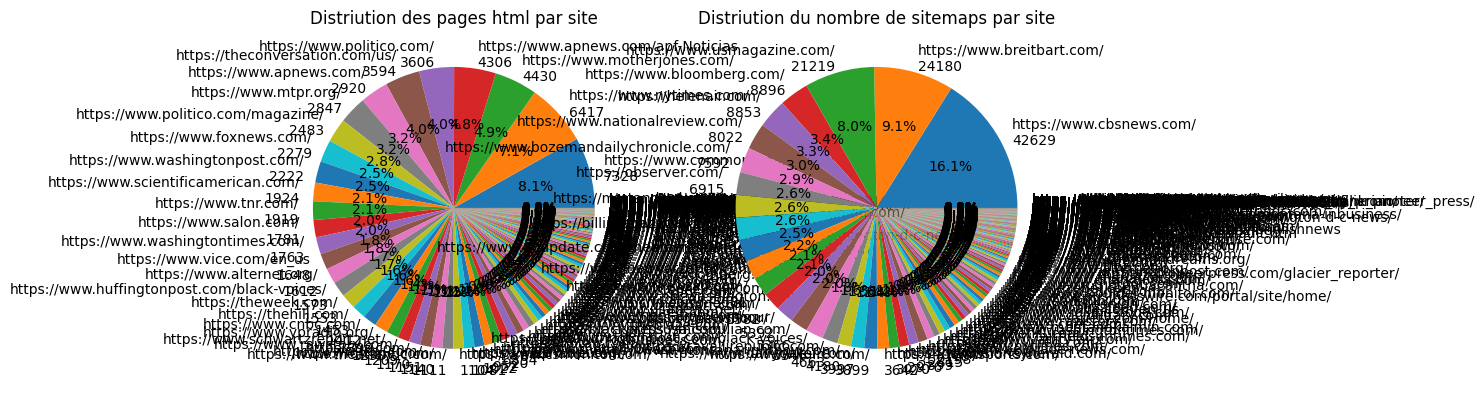

In [3]:
stat_end_sitemaps=list(client["scrapping"]["urls_sitemap_html"].aggregate([{"$unwind": "$sitemaps_xml"}, {"$group": {"_id" : "$url", "count" : {"$sum" : 1}}}]))
stat_end_html=list(client["scrapping"]["urls_sitemap_html"].aggregate([{"$unwind": "$html_urls"}, {"$group": {"_id" : "$url", "count" : {"$sum" : 1}}}]))
stat_end_sitemaps=sorted(stat_end_sitemaps, key=lambda x:x["count"], reverse=True)
stat_end_html=sorted(stat_end_html, key=lambda x:x["count"], reverse=True)


figure, axes = plt.subplots(1, 2, figsize=(10,10), dpi=100)
axes[0].pie(list(map(lambda x:x["count"], stat_end_html)), labels=list(map(lambda x:x["_id"]+"\n"+str(x["count"]), stat_end_html)),autopct='%1.1f%%')
axes[0].set_title("Distriution des pages html par site")
axes[1].pie(list(map(lambda x:x["count"], stat_end_sitemaps)), labels=list(map(lambda x:x["_id"]+"\n"+str(x["count"]), stat_end_sitemaps)),autopct='%1.1f%%')
axes[1].set_title("Distriution du nombre de sitemaps par site")
plt.show()
    

In [4]:
fig = px.bar(pd.DataFrame(stat_end_html), y='count', x='_id', title="Distribution des pages html par site")
fig

In [5]:
fig = px.bar(pd.DataFrame(stat_end_sitemaps), y='count', x='_id', title="Distribution des sitemaps par site")
fig

## Nombre de doublons

In [6]:
list(pd.DataFrame(stat_end_html).head(10).loc[:, "_id"])

['https://www.commondreams.org/',
 'https://www.nytimes.com/',
 'https://www.motherjones.com/',
 'https://www.apnews.com/apf-Noticias',
 'https://www.politico.com/',
 'https://theconversation.com/us/',
 'https://www.apnews.com/',
 'https://www.mtpr.org/',
 'https://www.politico.com/magazine/',
 'https://www.foxnews.com/']

## Nombre de sitemaps

In [7]:
pd.DataFrame(stat_end_sitemaps).loc[:, "count"].sum()

264393

In [8]:
url_climate=list(client["scrapping"]["urls_sitemap_html"].aggregate(
                                                    [
                                                        {"$unwind": "$html_urls"}, 
                                                        {"$match" : 
                                                            {
                                                                "$and":
                                                                    [
                                                                        {
                                                                            "html_urls.url" : # doit contenir le mot climat
                                                                                                { 
                                                                                                    '$regex' : '^(.*(climat)).*$', 
                                                                                                    '$options' : 'i'
                                                                                                },  
                                                                        }
                                                                    ]
                                                            }
                                                        },
                                                        { "$project": 
                                                                { 
                                                                    "_id":0,
                                                                    "html_urls.url": 1, 
                                                                    "url" : 1
                                                                }
                                                        }
                                                    ]
                                            )
                                    )

## Nombre d'élément uniques

In [9]:
df_urls_scrapped=pd.DataFrame(list(map(lambda x:{"url_website" : x["url"], "url":x["html_urls"]["url"]}, url_climate)))
len(df_urls_scrapped.loc[:, "url"].unique())

75270

In [31]:

liste_site_web=['https://www.nytimes.com/']

exemple_groupby=df_urls_scrapped.loc[df_urls_scrapped.loc[:, "url_website"].isin(liste_site_web),"url"]
def parsing(x):
    parsing_url=urllib.parse.urlparse(x)
    return [parsing_url.scheme]+[parsing_url.netloc]+parsing_url.path.strip('/').split("/")


list_split=exemple_groupby.apply(lambda x:parsing(x))
list_split



liste_parser=list(map(lambda x:list(zip(x[:-1], x[1:], [x[:k+2] for k in range(len(x))])), list(list_split)))

flat_parent_child = [ x for xs in liste_parser for x in xs ]
df_tree=pd.DataFrame(flat_parent_child)
df_tree.loc[:, "ids"]=df_tree.loc[:, 2].apply(lambda x:"-".join(x))
df_tree.loc[:, "parents"]=df_tree.loc[:, "ids"].shift(1)
df_tree.loc[df_tree.loc[:, 0]=="https", "parents"]=""
df_tree.drop(columns=[0,2], inplace=True)





df_tree=df_tree.merge(df_tree.loc[:, "ids"].value_counts().reset_index(), left_on='ids', right_on='ids').drop_duplicates()


df_tree=df_tree.loc[df_tree.loc[:, "ids"].isin(list(df_tree.loc[:, "parents"])), :]
go.Figure(
    go.Treemap(
ids = list(df_tree.loc[:, "ids"]),
labels = list(df_tree.loc[:, 1]),
parents = list(df_tree.loc[:, "parents"]),
values = list(df_tree.loc[:, "count"]),
branchvalues="total"
)
)


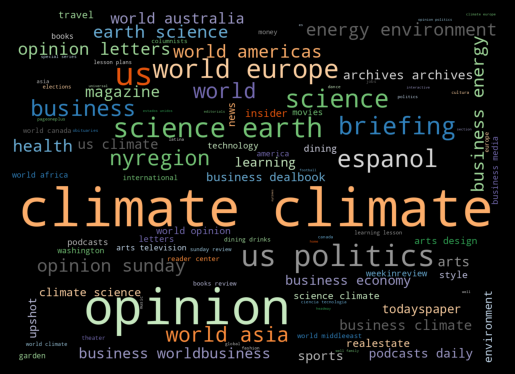

In [32]:
figure, axes = plt.subplots(1, 1, facecolor='k')

stop_words = set(stopwords.words('english'))
flat_list_word = [ x.lower() for xs in list(df_tree.loc[:, 1].apply(lambda x:x.split("-"))) for x in xs if x not in stop_words and len(x)!=1]

wordcloud = WordCloud(max_words = 100, width=1400, height=1000,  colormap='tab20c').generate(" ".join(flat_list_word))
axes.imshow(wordcloud)
axes.axis("off")
plt.show()

## Fox N

In [33]:
liste_site_web=['https://www.foxnews.com/']

exemple_groupby=df_urls_scrapped.loc[df_urls_scrapped.loc[:, "url_website"].isin(liste_site_web),"url"]
def parsing(x):
    parsing_url=urllib.parse.urlparse(x)
    return [parsing_url.scheme]+[parsing_url.netloc]+parsing_url.path.strip('/').split("/")


list_split=exemple_groupby.apply(lambda x:parsing(x))
list_split



liste_parser=list(map(lambda x:list(zip(x[:-1], x[1:], [x[:k+2] for k in range(len(x))])), list(list_split)))

flat_parent_child = [ x for xs in liste_parser for x in xs ]
df_tree=pd.DataFrame(flat_parent_child)
df_tree.loc[:, "ids"]=df_tree.loc[:, 2].apply(lambda x:"-".join(x))
df_tree.loc[:, "parents"]=df_tree.loc[:, "ids"].shift(1)
df_tree.loc[df_tree.loc[:, 0]=="https", "parents"]=""
df_tree.drop(columns=[0,2], inplace=True)





df_tree=df_tree.merge(df_tree.loc[:, "ids"].value_counts().reset_index(), left_on='ids', right_on='ids').drop_duplicates()


go.Figure(
    go.Treemap(
ids = list(df_tree.loc[:, "ids"]),
labels = list(df_tree.loc[:, 1]),
parents = list(df_tree.loc[:, "parents"]),
values = list(df_tree.loc[:, "count"]),
branchvalues="total"
)
)

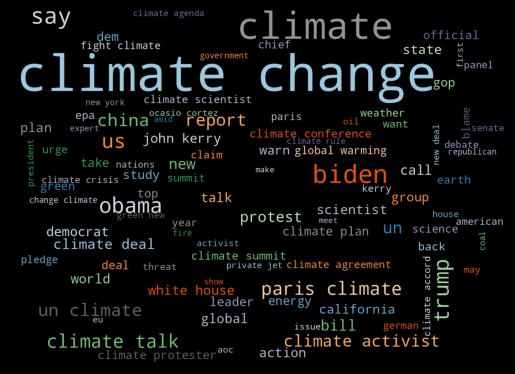

In [34]:
figure, axes = plt.subplots(1, 1, facecolor='k')

stop_words = set(stopwords.words('english'))
flat_list_word = [ x.lower() for xs in list(df_tree.loc[:, 1].apply(lambda x:x.split("-"))) for x in xs if x not in stop_words and len(x)!=1]

wordcloud = WordCloud(max_words = 100, width=1400, height=1000,  colormap='tab20c').generate(" ".join(flat_list_word))
axes.imshow(wordcloud)
axes.axis("off")
plt.show()

## Breibart

In [12]:
liste_site_web=['https://www.breitbart.com/']

exemple_groupby=df_urls_scrapped.loc[df_urls_scrapped.loc[:, "url_website"].isin(liste_site_web),"url"]
def parsing(x):
    parsing_url=urllib.parse.urlparse(x)
    return [parsing_url.scheme]+[parsing_url.netloc]+parsing_url.path.strip('/').split("/")


list_split=exemple_groupby.apply(lambda x:parsing(x))
list_split



liste_parser=list(map(lambda x:list(zip(x[:-1], x[1:], [x[:k+2] for k in range(len(x))])), list(list_split)))

flat_parent_child = [ x for xs in liste_parser for x in xs ]
df_tree=pd.DataFrame(flat_parent_child)
df_tree.loc[:, "ids"]=df_tree.loc[:, 2].apply(lambda x:"-".join(x))
df_tree.loc[:, "parents"]=df_tree.loc[:, "ids"].shift(1)
df_tree.loc[df_tree.loc[:, 0]=="https", "parents"]=""
df_tree.drop(columns=[0,2], inplace=True)





df_tree=df_tree.merge(df_tree.loc[:, "ids"].value_counts().reset_index(), left_on='ids', right_on='ids').drop_duplicates()


go.Figure(
    go.Treemap(
ids = list(df_tree.loc[:, "ids"]),
labels = list(df_tree.loc[:, 1]),
parents = list(df_tree.loc[:, "parents"]),
values = list(df_tree.loc[:, "count"]),
branchvalues="total"
)
)

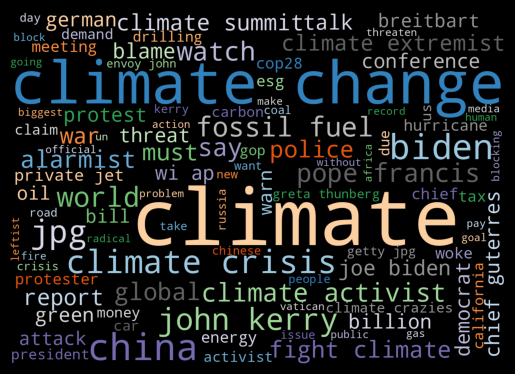

In [30]:
figure, axes = plt.subplots(1, 1, facecolor='k')

stop_words = set(stopwords.words('english'))
flat_list_word = [ x.lower() for xs in list(df_tree.loc[:, 1].apply(lambda x:x.split("-"))) for x in xs if x not in stop_words and len(x)!=1]

wordcloud = WordCloud(max_words = 100, width=1400, height=1000,  colormap='tab20c').generate(" ".join(flat_list_word))
axes.imshow(wordcloud)
axes.axis("off")
plt.show()